In [37]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [1]:
import torch
import torch.nn as nn

### Task 1

Write a function **word_2_vec(L)**. It takes a list L of strings (you can assume that the strings contain only lower-case letters, no number or special characters), and translate each string into a matrx (2d array) of nx26 where n is the number of letters in the string. (Different strings may have different length and thus different n.) Each row of the matrix is a one-hot vector (length 26) encoding the corresponding letter. For example, the encoding vector for the letter 'a' should be a vector of all zeros expect that the first entry should be one. The encoding vector for 'b' should have the second entry be one. The function should return a list of matrices, each corresponds to a string in L.   

[Use Python and Numpy only. No other packages. If you don't want to build by hand a letter-to-number dictionary, You may use Python function **ord(l)** to obtain the ascii value of the letter l.

In [2]:
import numpy as np
def word_2_vec(L):
  vec=[]
  for i in L:
    length=len(i)
    encode_vec=np.zeros((length,26))
    for j in range(length):
      index=ord(i[j])-97
      encode_vec[j][index]=1
    vec.append(encode_vec)
  return vec


In [3]:
for m in word_2_vec(['abc', 'to', 'vec']):
    print(m)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]]


### IMDb dataset


In [10]:
from keras.datasets import imdb

max_features = 20000  # use only this number of words (most common words) and ignore others
maxlen = 80  # make all review the same length (cutting longer ones and padding shorter ones)

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

25000 train sequences
25000 test sequences


In [11]:
min_id = min([min(x) for x in x_train])
max_id = max([max(x) for x in x_train])
print(min_id, max_id)

1 19999


### Task 2

Build a model to classify text. The inputs are imdb reviews and your model should read a review and predict whether the review is positive (1) or negative (0). Note that in the data, each review is a list of numbers (not words).



#### Task 2.1

Preprocess the data to make the sequence the same length (as defined by maxlen above).
After preprocessing, turn x_train and x_test into tensors so that you can create PyTorch dataloaders from these tensors.

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
x_train = [np.array(seq[:maxlen] + [0] * max(0, maxlen - len(seq)), dtype=np.int64) for seq in x_train]
x_test = [np.array(seq[:maxlen] + [0] * max(0, maxlen - len(seq)), dtype=np.int64) for seq in x_test]
x_train=torch.tensor(np.array(x_train)).to(device)
x_test=torch.tensor(np.array(x_test)).to(device)
y_train = torch.tensor(y_train).to(device)
y_test = torch.tensor(y_test).to(device)

Using device: cuda


#### Task 2.2

Build a model (subclass of nn.Module) with two layers of LSTM (each has 128 neurons/cells) for the text classification. Note that:
 - We don't use the word number as input directly. You need to use an embedding layer (nn.Embedding) to translate the word (number) into an vector. (You can set the length of the vector to be 128.)  
 - After going through the LSTM layers, give the LSTM output at the last position to a linear output layer to compute the probability of positive/negative.



In [15]:
from torch.utils.data import TensorDataset, DataLoader
train_data = TensorDataset(x_train, y_train)
test_data = TensorDataset(x_test, y_test)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data)
class LSTMclassifier(nn.Module):
  def __init__(self,input_size,embedding_dim,hidden_dim,output_dim):
    super().__init__()
    self.embedding=nn.Embedding(input_size,embedding_dim)
    self.lstm1=nn.LSTM(embedding_dim,hidden_dim,batch_first=True)
    self.lstm2=nn.LSTM(hidden_dim,hidden_dim,batch_first=True)
    self.linear=nn.Linear(hidden_dim,output_dim)

  def forward(self,x):
    embedded_inp=self.embedding(x)
    lstm_out1,_=self.lstm1(embedded_inp)
    lstm_out2,_=self.lstm2(lstm_out1)
    last_output=lstm_out2[:,-1,:]
    output=self.linear(last_output)
    return output

input_size=max_features
embedding_dim = 128
hidden_dim = 128
output_dim = 1

model = LSTMclassifier(input_size, embedding_dim, hidden_dim, output_dim).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


#### Task 2.3

After building your model, train it (20 epoches) on the train data and test it on the test data. Print out the accuracy on the test data.  

Epoch 1/20, Training Loss: 0.6727, Test Accuracy: 60.62%
Epoch 2/20, Training Loss: 0.6697, Test Accuracy: 50.61%
Epoch 3/20, Training Loss: 0.6214, Test Accuracy: 77.06%
Epoch 4/20, Training Loss: 0.4530, Test Accuracy: 85.29%
Epoch 5/20, Training Loss: 0.3509, Test Accuracy: 89.66%
Epoch 6/20, Training Loss: 0.2773, Test Accuracy: 93.20%
Epoch 7/20, Training Loss: 0.2134, Test Accuracy: 95.36%
Epoch 8/20, Training Loss: 0.1570, Test Accuracy: 97.30%
Epoch 9/20, Training Loss: 0.1100, Test Accuracy: 98.20%
Epoch 10/20, Training Loss: 0.0797, Test Accuracy: 98.26%
Epoch 11/20, Training Loss: 0.0558, Test Accuracy: 98.67%
Epoch 12/20, Training Loss: 0.0470, Test Accuracy: 99.01%
Epoch 13/20, Training Loss: 0.0410, Test Accuracy: 99.19%
Epoch 14/20, Training Loss: 0.0358, Test Accuracy: 99.52%
Epoch 15/20, Training Loss: 0.0331, Test Accuracy: 99.52%
Epoch 16/20, Training Loss: 0.0244, Test Accuracy: 99.63%
Epoch 17/20, Training Loss: 0.0244, Test Accuracy: 99.67%
Epoch 18/20, Training L

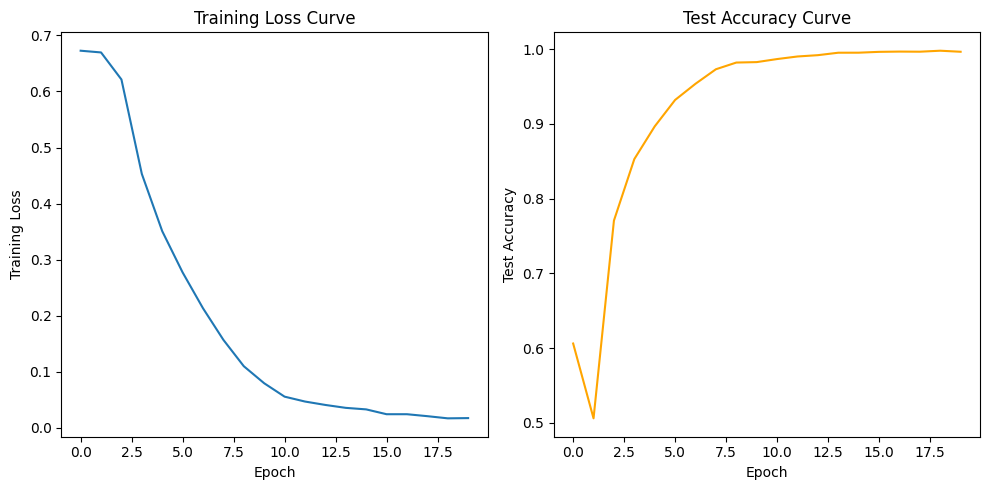

In [16]:
import matplotlib.pyplot as plt

# Training loop
epochs = 20
train_losses = []
test_accuracies = []
for epoch in range(epochs):
    running_loss = 0.0
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    # Evaluate accuracy on test data
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predicted = torch.round(torch.sigmoid(outputs))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    test_accuracies.append(accuracy)
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {epoch_loss:.4f}, Test Accuracy: {accuracy:.2%}")

plt.figure(figsize=(10, 5))

#training loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Curve')

#test accuracy curve
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, color='orange')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Curve')

plt.tight_layout()
plt.show()



In [17]:
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = torch.round(torch.sigmoid(outputs))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate accuracy
accuracy = correct / total
print(f"Accuracy on test data: {accuracy:.2%}")


Accuracy on test data: 99.64%
